In [1]:
from itertools import chain
import pandas as pd
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import string
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import numpy as np
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv("dataframe.csv")

In [4]:
import pandas as pd

def extract_context(sentence, connectives=['and', 'but'], num_words=2):
    context_df = pd.DataFrame(columns=['Words Before', 'Connective', 'Words After'])
    for conn in connectives:
        tokens = sentence.split()
        try:
            pos = tokens.index(conn)
        except ValueError:
            continue
        words_before = ' '.join([t for t in tokens[max(0, pos-num_words):pos] if t.isalpha()]) # .isalpha is checking whether using letters, making sure there aren't any commas
        words_after = ' '.join([t for t in tokens[pos+1:min(len(tokens), pos+1+num_words)] if t.isalpha()])
        context_df = pd.concat([context_df,
                                pd.DataFrame({'Words Before': [words_before],
                                              'Connective': [conn],
                                              'Words After': [words_after]})],
                                ignore_index=True)    
    return context_df



This code defines a function called extract_context, which takes a sentence as input along with optional parameters for connectives and num_words (the number of words to extract before and after the connective). The function uses the pandas library to create an empty dataframe, then loops through each connective and tokenizes the sentence into words. It then finds the position of the connective, extracts the specified number of words before and after it (excluding punctuation), and appends them to the dataframe. Finally, the function returns the completed dataframe of extracted context words.





In [5]:
df_sentences = data[['sentence']]


In [6]:
context_df = pd.concat([extract_context(sentence) for sentence in df_sentences['sentence']])


In [7]:
context_df

,Words Before,Connective,Words After
0,was,but,then all
0,movement,and,later the
0,guilt,but,in the
0,Great Society,and,then to
0,in housing,and,education
...,...,...,...
0,While walking,and,cycling are
0,car ownership,and,and
0,learning,and,economic and
0,not industry,but,a specific


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(context_df['Words Before'] + ' ' + context_df['Connective'] + ' ' + context_df['Words After'])

vectors = vectorizer.transform(context_df['Words Before'] + ' ' + context_df['Connective'] + ' ' + context_df['Words After'])

vector_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())


C:\Users\varun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This code uses the TfidfVectorizer class from the sklearn library to create a vectorizer object that can transform sentences into numerical vectors using the TF-IDF (term frequency-inverse document frequency) algorithm. The fit method is used to fit the vectorizer to the sentences in the context_df dataframe, which contains the context words extracted by the previous code. Then, the transform method is called to convert the sentences into vectors, and the resulting vectors are stored in a dataframe called vector_df. Finally, the column names of the dataframe are set to the feature names returned by the vectorizer's get_feature_names method, which are the words that were used to create the vectorized representation of the sentences.


Term frequency (TF): This is the frequency of a word in a document, normalized by the total number of words in that document. The idea is that a word that appears frequently in a document is more important than a word that appears only once.

Inverse document frequency (IDF): This is a measure of how rare a word is across all documents in the collection. The IDF of a word is calculated by taking the logarithm of the total number of documents in the collection divided by the number of documents that contain the word. The idea is that a word that appears in many documents is less important than a word that appears in few documents.




In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

kmeans.fit(vectors)

context_df['Cluster'] = kmeans.labels_


In [19]:
context_df

,Words Before,Connective,Words After,Cluster
0,was,but,then all,2
0,movement,and,later the,3
0,guilt,but,in the,0
0,Great Society,and,then to,4
0,in housing,and,education,0
...,...,...,...,...
0,While walking,and,cycling are,4
0,car ownership,and,and,4
0,learning,and,economic and,4
0,not industry,but,a specific,2


In [26]:
import pandas as pd

cluster_counts = context_df.groupby('Cluster').size().reset_index(name='count')
print(cluster_counts)


   Cluster  count
0        0   1783
1        1   3305
2        2   2913
3        3   4961
4        4  22009


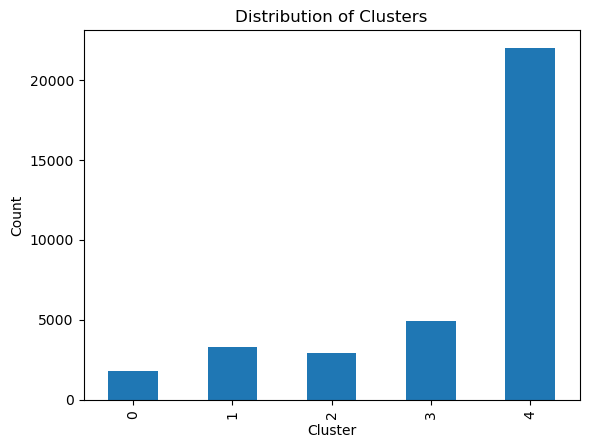

In [28]:
import matplotlib.pyplot as plt

cluster_counts.plot(kind='bar', x='Cluster', y='count', legend=None)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [31]:
import nltk

def get_most_common_words(cluster):
    tokens = []
    for index, row in context_df.iterrows():
        if row['Cluster'] == cluster:
            tokens += nltk.word_tokenize(row['Words Before'] + ' ' + row['Connective'] + ' ' + row['Words After'])
    fdist = nltk.FreqDist(tokens)
    return fdist.most_common(10)

for i in range(5):
    print('Cluster', i)
    print(get_most_common_words(i))


Cluster 0
[('in', 1819), ('and', 1643), ('the', 172), ('but', 151), ('of', 106), ('a', 48), ('their', 34), ('for', 30), ('to', 30), ('also', 24)]
Cluster 1
[('of', 3373), ('and', 3340), ('the', 691), ('a', 75), ('to', 63), ('that', 47), ('teaching', 43), ('The', 42), ('as', 39), ('learning', 38)]
Cluster 2
[('but', 2912), ('the', 431), ('also', 258), ('it', 197), ('not', 186), ('a', 183), ('is', 170), ('to', 168), ('of', 124), ('rather', 107)]
Cluster 3
[('the', 5293), ('and', 4948), ('to', 193), ('The', 128), ('that', 115), ('a', 71), ('their', 68), ('its', 67), ('at', 57), ('by', 57)]
Cluster 4
[('and', 22221), ('to', 1408), ('a', 981), ('for', 770), ('that', 572), ('by', 538), ('their', 464), ('with', 462), ('are', 446), ('on', 430)]
